# Analysis of MQTT Input Data

In [ ]:
recording_file = "2020-06-02T10-31-46"
load_until_seconds = 30 * 60

In [2]:
import boto3
import re
import base64
import json
from datetime import datetime, timedelta
from dateutil.parser import isoparse
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import bz2
from ptinsight.common.plotting import plot_init, plot_subplot, plot_format, plot_save, add_relative_time
from ptinsight.common.recordings import open_recording

plot_init()

In [3]:
def load_timestamps():
    csv_writer = csv.writer(open(
        f"results/{recording_file}.csv",
        "w",
        encoding="utf-8",
        newline="",
        buffering=1,
    ))
    csv_writer.writerow(("event_type", "ingestion_timestamp", "event_timestamp"))

    s3_file = boto3.resource("s3").Object("mqtt-recordings", f"mqtt.hsl.fi/{recording_file}.rec.bz2")

    body, lines = open_recording(s3_file)

    original_broker = next(lines)[8:]
    original_topics = next(lines)[8:]
    original_t_start = isoparse(next(lines)[12:]).replace(
        microsecond=0
    )
    next(lines)

    print(f"Recorded from {original_broker} at {str(original_t_start)}")
    print(f"Topics: {original_topics}\n")

    message_regex = re.compile(r'(\S+) "(.+)" (\d) (\d) (\S*)')

    for i, line in enumerate(lines):
        t_offset, topic, _, _, payload = message_regex.match(line).groups()
        t_offset = float(t_offset)
        payload = json.loads(base64.b64decode(payload))

        event_type = list(payload.keys())[0]
        if not event_type in ["VP", "ARS", "DEP"]:
            continue
            
        if i%5000 == 0:
            print(f"{i=} {t_offset}")

        if t_offset >= load_until_seconds:
            break

        ingestion_timestamp = original_t_start + timedelta(seconds=t_offset)
        event_timestamp = isoparse(payload[event_type]["tst"])
        csv_writer.writerow((event_type.lower(), ingestion_timestamp.timestamp() * 1000, event_timestamp.timestamp() * 1000))
        
    body.close()

In [4]:
# Takes a very long time! Only use for new recordings
# load_timestamps()

In [5]:
def analyze_operators():
    s3_file = boto3.resource("s3").Object("mqtt-recordings", f"mqtt.hsl.fi/{recording_file}.rec.bz2")

    body, lines = open_recording(s3_file)
    
    for _ in range(4):
       next(lines)
    
    message_regex = re.compile(r'(\S+) "(.+)" (\d) (\d) (\S*)')
    
    operators = set()

    for i, line in enumerate(lines):
        _, _, _, _, payload = message_regex.match(line).groups()
        payload = json.loads(base64.b64decode(payload))

        event_type = list(payload.keys())[0]
        if not event_type in ["VP", "ARS", "DEP"]:
            continue

        if i >= 50000:
            break

        operators.add(payload[event_type]["oper"])

    print(operators)
    print(f"min: {min(operators)}")
    print(f"max: {max(operators)}")
    
    body.close()
analyze_operators()

{36, 58, 6, 40, 12, 47, 17, 50, 20, 21, 22, 54, 90, 59, 60, 30}
min: 6
max: 90


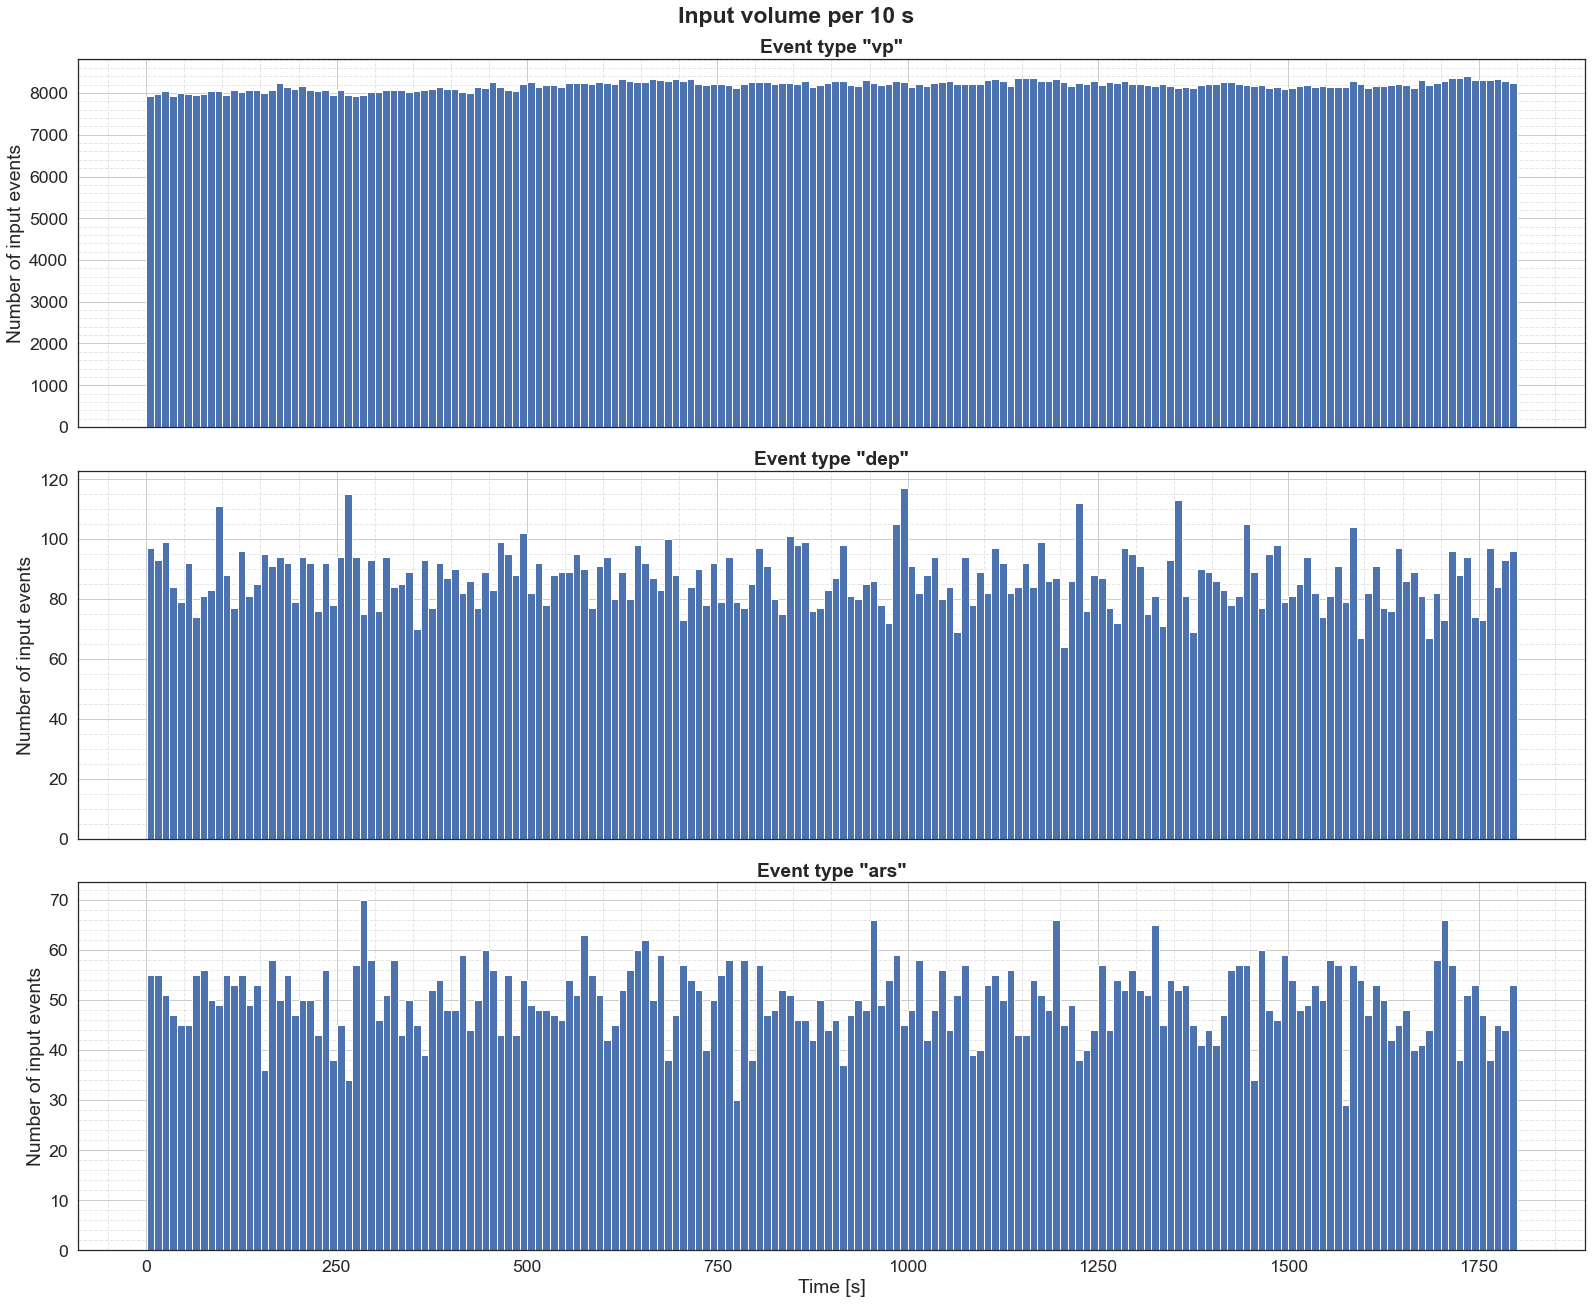

In [6]:
def plot_timestamps():
    data = pd.read_csv(f"results/{recording_file}.csv")
    add_relative_time(data, "ingestion_timestamp")
    
    event_types = pd.unique(data["event_type"])
    n_event_types = len(event_types)
    
    fig, axs = plot_subplot(n_event_types)
    fig.suptitle("Input volume per 10 s")
    
    for i, event_type in enumerate(event_types):
        ax = axs[i]
        
        event_type_data = data[data["event_type"] == event_type]
        ax.hist(event_type_data["t"], bins=30*6)
        
        if i == n_event_types-1:
            plt.xlabel("Time [s]")
        ax.set_ylabel("Number of input events")
        ax.set_title(f"Event type \"{event_type}\"")
    
    plot_format(fig)
    plot_save(f"ingestion_timestamp")
    
plot_timestamps()

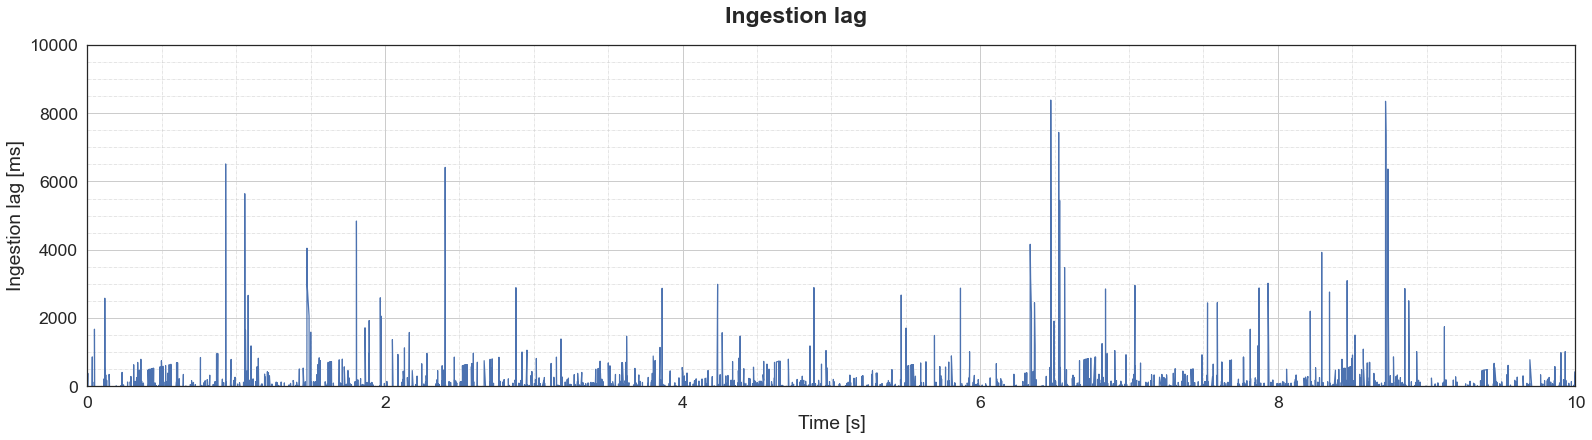

In [7]:
def plot_timelag_over_time():
    data = pd.read_csv(f"results/{recording_file}.csv")
    data["time_lag"] = data["ingestion_timestamp"] - data["event_timestamp"]
    add_relative_time(data, "ingestion_timestamp")
    
    fig, axs = plot_subplot()
    ax = axs[0]
    fig.suptitle(f"Ingestion lag")

    ax.plot(data["t"], data["time_lag"])
#     ax.plot(data["ingestion_timestamp"] - data["ingestion_timestamp"][0], data["event_timestamp"] - data["event_timestamp"][0])

    ax.set_xlim([0, 10])
    ax.set_ylim([0, 10000])
    ax.set_ylabel("Ingestion lag [ms]")
    ax.set_xlabel("Time [s]")

    plot_format(fig)
    plot_save(f"time_lag")
    
plot_timelag_over_time()

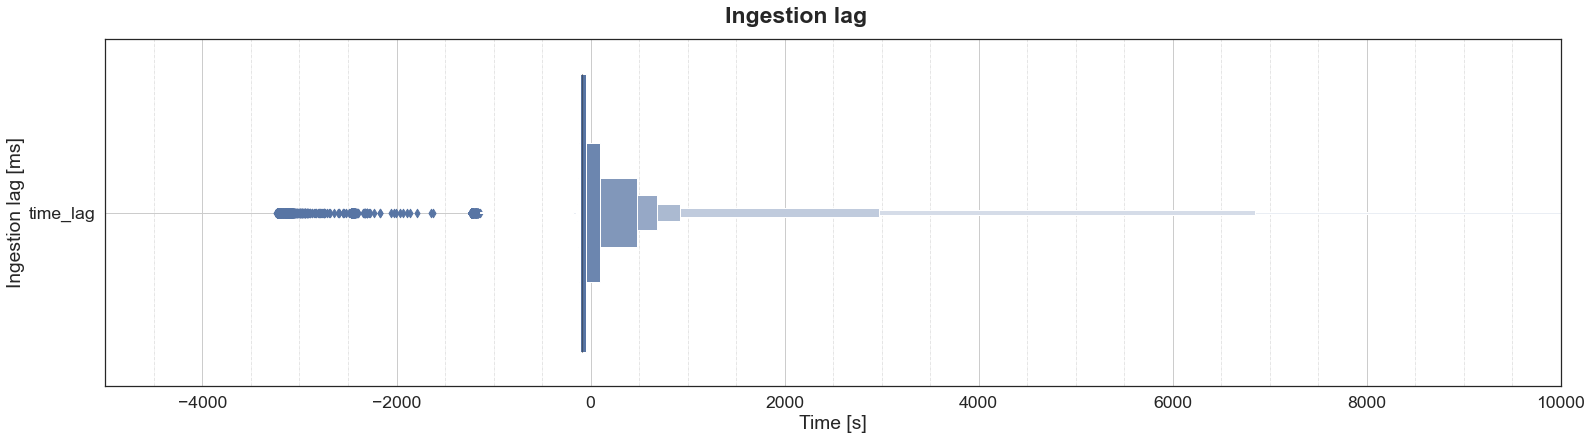

In [8]:
def plot_timelag_distribution():
    data = pd.read_csv(f"results/{recording_file}.csv")
    data["time_lag"] = data["ingestion_timestamp"] - data["event_timestamp"]
    
    fig, axs = plot_subplot()
    ax = axs[0]
    fig.suptitle(f"Ingestion lag")

    sb.boxenplot(data=data[["time_lag"]], orient="h")
    ax.set_xlim([-5000, 10000])
    ax.set_ylabel("Ingestion lag [ms]")
    ax.set_xlabel("Time [s]")

    plot_format(fig)
    plot_save(f"time_lag")
    
plot_timelag_distribution()